<a href="https://colab.research.google.com/github/gabi-farias/Deep-Learning-Project/blob/main/BRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep learning project aa 2023/24

Libraries

In [ ]:
import os
import threading
import time
import sys

import torch as th
import torch.nn as nn
import numpy as np
import pandas as pd
import tensorflow as tf
import torch.optim as optim
import torch.nn.functional as F

# For the progress bar
from tqdm import tqdm

Function that perform the onehot encoding

In [ ]:
def onehot_encoder(dataset):
    """
    Function that encodes a DNA dataset into a onehot encoding dataset.
    """
    onehot_dataset = [dna_onehot_encoder(dna_string) for dna_string in dataset]
    onehot_dataset_numpy = np.array(onehot_dataset)

    return onehot_dataset_numpy


def dna_onehot_encoder(dna_sequence):
    """
    Function that encodes a single DNA string into a onehot encoding string.
    """
    onehot_dict = {
        'A' : [1, 0, 0, 0],
        'C' : [0, 1, 0, 0],
        'G' : [0, 0, 1, 0],
        'T' : [0, 0, 0, 1]
    }
    encoder = [onehot_dict[nuc] for nuc in dna_sequence]

    return encoder

Data encoding

In [ ]:
#! - TESTER
path = 'fullset_test.csv'

# Read the input from the csv file
csv = pd.read_csv(path, sep=",")
# Drop the NaN values
csv = csv.dropna()
# Describe the data
csv.describe()

# Get the data from the csv file
data = csv.values
# m = number of input samples
m = data.shape[0]
print("Amount of data:",m)
X = data[:m,1]
Y = data[:m,2].astype(np.int32)

# # Reduce the size of the dataset for testing
m = 5
X = X[:m]
Y = Y[:m]

# OneHot encoding for the training data
print("Start onehot encoding for the training data")
X = onehot_encoder(X)

# Convert the data to a tensor
X = th.tensor(X)
Y = th.tensor(Y)

print("X_train shape: ", X.shape)
print("Y_train shape: ", Y.shape)

# Free memory
del csv, data, m

Amount of data: 26404
Start onehot encoding for the training data
X_train shape:  torch.Size([5, 300, 4])
Y_train shape:  torch.Size([5])


In [ ]:
#!- MAIN

# Set the device to be used (GPU or CPU)
device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Device: ", device)

# Read the input from the cvc file
rel_path_train = 'fullset_train.csv'
rel_path_val = 'fullset_validation.csv'
rel_path_test = 'fullset_test.csv'

# Training Set

# Read the input from the csv file
train_csv = pd.read_csv(rel_path_train, sep=",")
# Drop the NaN values
train_csv = train_csv.dropna()
# Describe the data
train_csv.describe()

# Get the data from the csv file
train_data = train_csv.values
# m = number of input samples
m = train_data.shape[0]
print("Amount of data:",m)
X_train = train_data[:m,1]
Y_train = train_data[:m,2].astype(np.int32)

# # Reduce the size of the dataset for testing
# m = 100000
# X_train = X_train[:m]
# Y_train = Y_train[:m]

# OneHot encoding for the training data
print("Start onehot encoding for the training data")
X_train = onehot_encoder(X_train)

# Convert the data to a tensor
X_train = th.from_numpy(X_train)
Y_train = th.tensor(Y_train)

print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)

# Free memory
del train_csv, train_data, m

# Validation Set

# Read the input from the csv file
val_csv = pd.read_csv(rel_path_val, sep=",")
# Drop the NaN values
val_csv = val_csv.dropna()
# Describe the data
val_csv.describe()

val_data = val_csv.values
# m = number of input samples
m = val_data.shape[0]
print("Amount of data:",m)
X_val = val_data[:m,1]
Y_val = val_data[:m,2].astype(np.int32)

# OneHot encoding for the validation data
print("Start onehot encoding for the validation data")
X_val = onehot_encoder(X_val)

X_val = th.from_numpy(X_val)
Y_val = th.tensor(Y_val)

print("X_val shape", X_val.shape)
print("Y_val shape", Y_val.shape)

# Free memory
del val_csv, val_data, m

# Test

# Read the input from the csv file
test_csv = pd.read_csv(rel_path_test, sep=",")
# Drop the NaN values
test_csv = test_csv.dropna()
# Describe the data
test_csv.describe()

test_data = test_csv.values
# m = number of input samples
m = test_data.shape[0]
print("Amount of data:",m)
X_test = test_data[:m,1]
Y_test = test_data[:m,2].astype(np.int32)

# OneHot encoding for the test data
print("Start onehot encoding for the test data")
X_test = onehot_encoder(X_test)

X_test = th.from_numpy(X_test)
Y_test = th.tensor(Y_test)

print("X_test shape", X_test.shape)
print("Y_test shape", Y_test.shape)

# Free memory
del test_csv, test_data, m

Device:  cpu
Amount of data: 87661
Start onehot encoding for the training data
X_train shape:  torch.Size([87661, 300, 4])
Y_train shape:  torch.Size([87661])
Amount of data: 26404
Start onehot encoding for the validation data
X_val shape torch.Size([26404, 300, 4])
Y_val shape torch.Size([26404])
Amount of data: 26404
Start onehot encoding for the test data
X_test shape torch.Size([26404, 300, 4])
Y_test shape torch.Size([26404])


Train the model

#BRNN

#Definition cross-entropy loss:

\begin{equation}
{Loss} = - \frac{1}{N} \sum_{i=1}^{N} \sum_{c=1}^{C} y_{i,c} \log({p}_{i})
\end{equation}

where:
   Loss is the cross-entropy loss,
   N is the number of samples,
   C is the number of classes,
   y_{i} is the binary indicator (0 or 1) if class label c is the correct classification for sample i,
   p_{i} is the predicted probability that sample i belongs to class c.

In [ ]:
def cross_entropy_loss(predictions, targets):
    """
    Calculate the cross-entropy loss manually.

    Parameters:
    - predictions (Tensor): The predicted probabilities (output from softmax).
    - targets (Tensor): The true labels (as integers).

    Returns:
    - loss (Tensor): The cross-entropy loss.
    """
    # Apply log softmax to predictions
    log_softmax_preds = th.log(predictions)

    # Select the log probabilities corresponding to the correct labels
    selected_log_preds = log_softmax_preds[range(predictions.shape[0]), targets]

    # Compute the negative mean of these values
    loss = -th.mean(selected_log_preds)

    return loss


#Define Adam Optimizer

In [ ]:
class AdamOptimizer:
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-8):
        self.params = list(params)
        self.lr = lr
        self.betas = betas
        self.eps = eps
        self.t = 0

        # Initialize the first and second moment vectors
        self.m = [th.zeros_like(p) for p in self.params]
        self.v = [th.zeros_like(p) for p in self.params]

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def step(self):
        self.t += 1
        beta1, beta2 = self.betas

        for i, param in enumerate(self.params):
            if param.grad is None:
                continue

            grad = param.grad.data
            self.m[i] = beta1 * self.m[i] + (1 - beta1) * grad
            self.v[i] = beta2 * self.v[i] + (1 - beta2) * grad**2

            m_hat = self.m[i] / (1 - beta1**self.t)
            v_hat = self.v[i] / (1 - beta2**self.t)

            param.data -= self.lr * m_hat / (th.sqrt(v_hat) + self.eps)

#Define the BRNN Model

In [ ]:
class BRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(BRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Embedding layer (optional, useful for text data)
        self.embedding = nn.Embedding(input_size, hidden_size)

        # Bidirectional RNN layer
        self.rnn = nn.RNN(hidden_size, hidden_size, num_layers, bidirectional=True, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        # x: (batch_size, seq_length)
        x = self.embedding(x)  # x: (batch_size, seq_length, hidden_size)

        # Initialize hidden state with zeros
        h0 = th.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)  # 2 for bidirection

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)  # out: (batch_size, seq_length, hidden_size * 2)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])  # out: (batch_size, output_size)

        return out


#Initialize the Model and optimizer




In [ ]:
# Model parameters
input_size = 10  # Vocabulary size
hidden_size = 20
output_size = 2  # Number of classes for classification
num_layers = 1
learning_rate = 0.001

model = BRNN(input_size, hidden_size, output_size, num_layers)

# Custom Adam optimizer
optimizer = AdamOptimizer(model.parameters(), lr=learning_rate)

#Training with Validation

In [ ]:
# Dummy data: batch_size x seq_length
batch_size = 5
seq_length = 7

# Generate some random sequences (encoded as 0-3) and labels for training and validation
data = th.randint(0, input_size, (batch_size, seq_length))
labels = th.randint(0, output_size, (batch_size,))
val_data = th.randint(0, input_size, (batch_size, seq_length))
val_labels = th.randint(0, output_size, (batch_size,))

# Lists to store the metrics
train_losses = []
val_losses = []
val_accuracies = []

# Training Cross Entropy Loss and Adam Optimizer

In [ ]:
# Training loop with validation
num_epochs = 100

for epoch in range(num_epochs):
    # Training phase
    model.train()
    optimizer.zero_grad()
    outputs = model(data)
    predictions = F.softmax(outputs, dim=1)
    loss = cross_entropy_loss(predictions, labels)
    loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with th.no_grad():
        val_outputs = model(val_data)
        val_predictions = F.softmax(val_outputs, dim=1)
        val_loss = cross_entropy_loss(val_predictions, val_labels)

        # Calculate accuracy
        _, predicted = th.max(val_predictions, 1)
        val_accuracy = (predicted == val_labels).float().mean().item()

        # Store the metrics
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())
        val_accuracies.append(val_accuracy)

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}')


Epoch [10/100], Loss: 0.5360, Val Loss: 0.6629, Val Accuracy: 0.6000
Epoch [20/100], Loss: 0.3304, Val Loss: 0.5795, Val Accuracy: 0.6000
Epoch [30/100], Loss: 0.1944, Val Loss: 0.5232, Val Accuracy: 0.6000
Epoch [40/100], Loss: 0.1110, Val Loss: 0.5021, Val Accuracy: 0.6000
Epoch [50/100], Loss: 0.0646, Val Loss: 0.5107, Val Accuracy: 0.6000
Epoch [60/100], Loss: 0.0405, Val Loss: 0.5376, Val Accuracy: 0.6000
Epoch [70/100], Loss: 0.0279, Val Loss: 0.5732, Val Accuracy: 0.6000
Epoch [80/100], Loss: 0.0207, Val Loss: 0.6107, Val Accuracy: 0.6000
Epoch [90/100], Loss: 0.0162, Val Loss: 0.6469, Val Accuracy: 0.6000
Epoch [100/100], Loss: 0.0132, Val Loss: 0.6808, Val Accuracy: 0.6000


#Visualisation

In [ ]:
import matplotlib.pyplot as plt

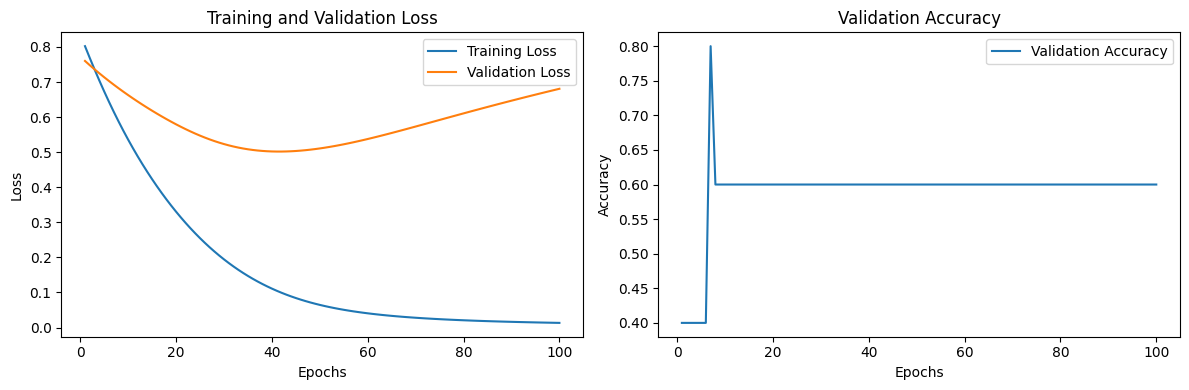

In [ ]:
# Plot the metrics
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()